# Importing Libraries

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras

import cv2
import os

# importing keras libraries
from keras.models import Model, load_model
from keras.layers import Input, BatchNormalization, Dense, Dropout
from keras.layers.core import Lambda, RepeatVector, Reshape
from keras.layers.convolutional import Conv2D, Conv2DTranspose
from keras.layers.pooling import MaxPooling2D, GlobalMaxPool2D # pooling
from keras.optimizers import Adam # optimiser
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img

from skimage.transform import resize
from glob import glob # to save path
from sklearn.model_selection import train_test_split # train-val split

# Loading Data

In [2]:
# parameters
im_width = 128
im_height = 128
border = 5

In [3]:
# list of names all images in the given path
images = next(os.walk("/home/lakshita/data_semantics/training/image_2/"))[2] 
# no of images
print(len(images))
# print(images)

200


In [4]:
traindata_path = "/home/lakshita/data_semantics/training/"
x_train = sorted(glob(os.path.join(traindata_path, "image_2", "*.png")))
y_train = sorted(glob(os.path.join(traindata_path, "semantic", "*.png")))

In [5]:
print(x_train)
print(y_train)

['/home/lakshita/data_semantics/training/image_2/000000_10.png', '/home/lakshita/data_semantics/training/image_2/000001_10.png', '/home/lakshita/data_semantics/training/image_2/000002_10.png', '/home/lakshita/data_semantics/training/image_2/000003_10.png', '/home/lakshita/data_semantics/training/image_2/000004_10.png', '/home/lakshita/data_semantics/training/image_2/000005_10.png', '/home/lakshita/data_semantics/training/image_2/000006_10.png', '/home/lakshita/data_semantics/training/image_2/000007_10.png', '/home/lakshita/data_semantics/training/image_2/000008_10.png', '/home/lakshita/data_semantics/training/image_2/000009_10.png', '/home/lakshita/data_semantics/training/image_2/000010_10.png', '/home/lakshita/data_semantics/training/image_2/000011_10.png', '/home/lakshita/data_semantics/training/image_2/000012_10.png', '/home/lakshita/data_semantics/training/image_2/000013_10.png', '/home/lakshita/data_semantics/training/image_2/000014_10.png', '/home/lakshita/data_semantics/training

In [6]:
import random
from PIL import Image

In [7]:
img_folder = "/home/lakshita/data_semantics/training/image_2/"
mask_folder = "/home/lakshita/data_semantics/training/semantic/"
file = random.choice(os.listdir(img_folder))
image_path= os.path.join(img_folder, file)
img = cv2.imread(os.path.join(img_folder, "000006_10.png"))
mask = cv2.imread(os.path.join(mask_folder, "000006_10.png"))

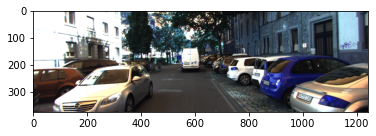

In [8]:
plt.imshow(img)

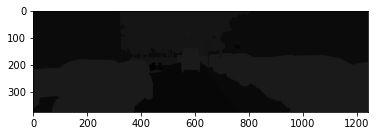

In [9]:
plt.imshow(mask)

In [10]:
# split into train-val set
x_train, x_validation, y_train, y_validation = train_test_split(x_train, y_train, test_size=0.15, random_state=1)

# Unet Model

In [11]:
def conv2d_block(input_tensor, n_filters, kernel_size = 3):
    
    # conv2d layer #1
    x = Conv2D(filters = n_filters, kernel_size = (kernel_size, kernel_size), kernel_initializer = 'he_normal', padding = 'same')(input_tensor)
    
    
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.Activation('relu')(x)
    # conv2d layer #2
    x = Conv2D(filters = n_filters, kernel_size = (kernel_size, kernel_size), kernel_initializer = 'he_normal', padding = 'same')(input_tensor)
    
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.Activation('relu')(x)

    return x

def get_unet(input_img, n_filters = 16, dropout = 0.1):
    
    c1 = conv2d_block(input_img, n_filters*1, kernel_size = 3)
    p1 = MaxPooling2D((2, 2))(c1)
    p1 = Dropout(dropout)(p1)
    
    c2 = conv2d_block(p1, n_filters*2, kernel_size = 3)
    p2 = MaxPooling2D((2, 2))(c2)
    p2 = Dropout(dropout)(p2)
    
    c3 = conv2d_block(p2, n_filters*4, kernel_size = 3)
    p3 = MaxPooling2D((2, 2))(c3)
    p3 = Dropout(dropout)(p3)
    
    
    c4 = conv2d_block(p3, n_filters*8, kernel_size = 3)
    p4 = MaxPooling2D((2, 2))(c4)
    p4 = Dropout(dropout)(p4)

    c5 = conv2d_block(p4, n_filters = n_filters*16, kernel_size = 3)

    outputs = Conv2D(1, (1, 1), activation='sigmoid')(c5)
    model = Model(inputs=[input_img], outputs=[outputs])
    return model

In [12]:
input_img = keras.layers.Input((im_height, im_width, 1), name='images')
model = get_unet(input_img, n_filters=16, dropout=0.05)
model.compile(optimizer=Adam(), loss="binary_crossentropy", metrics=["accuracy"])

# Model Training

In [13]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
images (InputLayer)          [(None, 128, 128, 1)]     0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 128, 128, 16)      160       
_________________________________________________________________
batch_normalization_1 (Batch (None, 128, 128, 16)      64        
_________________________________________________________________
activation_1 (Activation)    (None, 128, 128, 16)      0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 64, 64, 16)        0         
_________________________________________________________________
dropout (Dropout)            (None, 64, 64, 16)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 64, 64, 32)        4640  

In [14]:
# there's an error for incorrect input dimension i think
# working on it
model.fit(x_train, y_train, batch_size=32, epochs=10, validation_data=(x_validation, y_validation))

Epoch 1/10


ValueError: in user code:

    /home/lakshita/anaconda3/envs/tf-gpu/lib/python3.9/site-packages/tensorflow/python/keras/engine/training.py:805 train_function  *
        return step_function(self, iterator)
    /home/lakshita/anaconda3/envs/tf-gpu/lib/python3.9/site-packages/tensorflow/python/keras/engine/training.py:795 step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    /home/lakshita/anaconda3/envs/tf-gpu/lib/python3.9/site-packages/tensorflow/python/distribute/distribute_lib.py:1259 run
        return self._extended.call_for_each_replica(fn, args=args, kwargs=kwargs)
    /home/lakshita/anaconda3/envs/tf-gpu/lib/python3.9/site-packages/tensorflow/python/distribute/distribute_lib.py:2730 call_for_each_replica
        return self._call_for_each_replica(fn, args, kwargs)
    /home/lakshita/anaconda3/envs/tf-gpu/lib/python3.9/site-packages/tensorflow/python/distribute/distribute_lib.py:3417 _call_for_each_replica
        return fn(*args, **kwargs)
    /home/lakshita/anaconda3/envs/tf-gpu/lib/python3.9/site-packages/tensorflow/python/keras/engine/training.py:788 run_step  **
        outputs = model.train_step(data)
    /home/lakshita/anaconda3/envs/tf-gpu/lib/python3.9/site-packages/tensorflow/python/keras/engine/training.py:754 train_step
        y_pred = self(x, training=True)
    /home/lakshita/anaconda3/envs/tf-gpu/lib/python3.9/site-packages/tensorflow/python/keras/engine/base_layer.py:1012 __call__
        outputs = call_fn(inputs, *args, **kwargs)
    /home/lakshita/anaconda3/envs/tf-gpu/lib/python3.9/site-packages/tensorflow/python/keras/engine/functional.py:424 call
        return self._run_internal_graph(
    /home/lakshita/anaconda3/envs/tf-gpu/lib/python3.9/site-packages/tensorflow/python/keras/engine/functional.py:560 _run_internal_graph
        outputs = node.layer(*args, **kwargs)
    /home/lakshita/anaconda3/envs/tf-gpu/lib/python3.9/site-packages/tensorflow/python/keras/engine/base_layer.py:998 __call__
        input_spec.assert_input_compatibility(self.input_spec, inputs, self.name)
    /home/lakshita/anaconda3/envs/tf-gpu/lib/python3.9/site-packages/tensorflow/python/keras/engine/input_spec.py:234 assert_input_compatibility
        raise ValueError('Input ' + str(input_index) + ' of layer ' +

    ValueError: Input 0 of layer conv2d_1 is incompatible with the layer: : expected min_ndim=4, found ndim=2. Full shape received: (None, 1)
